**<h1>Исследование сервиса аренды самокатов GoFast**

Цель исследования — проанализировать сервис аренды самокатов GoFast и проверить некоторые гипотезы, которые могут помочь бизнесу вырасти.


Чтобы совершать поездки по городу, пользователи сервиса GoFast пользуются мобильным приложением. Сервисом можно пользоваться:

без подписки
* абонентская плата отсутствует;

* стоимость одной минуты поездки — 8 рублей;

* стоимость старта (начала поездки) — 50 рублей;

с подпиской Ultra

* абонентская плата — 199 рублей в месяц;

* стоимость одной минуты поездки — 6 рублей;

* стоимость старта — бесплатно.

**Описание даных:**

Пользователи — users_go.csv:
user_id — уникальный идентификатор пользователя;
name — имя пользователя;
age — возраст;
city — город;
subscription_type — тип подписки (free, ultra).

Поездки — rides_go.csv:
user_id — уникальный идентификатор пользователя;
distance — расстояние, которое пользователь проехал в текущей сессии (в метрах);
duration — продолжительность сессии (в минутах) — время с того момента, как пользователь нажал кнопку «Начать поездку» до момента, как он нажал кнопку «Завершить поездку»;
date — дата совершения поездки.

Подписки — subscriptions_go.csv:
subscription_type — тип подписки;
minute_price — стоимость одной минуты поездки по данной подписке;
start_ride_price — стоимость начала поездки;
subscription_fee — стоимость ежемесячного платёж.

**План работ:**

1. Загрузка данных
2. Предобработка данных
3. Исследовательский анализ данных
4. Объединение данных
5. Подсчёт выручки
6. Проверка гипотез

#### Шаг 1. Загрузка данных

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from plotly import graph_objects as go
import plotly.express as px
import numpy as np
from scipy import stats as st
from scipy.stats import binom, poisson, norm
from math import sqrt, factorial

plt.style.use('seaborn-pastel')

In [2]:
users = pd.read_csv('/datasets/users_go.csv')
rides = pd.read_csv('/datasets/rides_go.csv')
subscriptions = pd.read_csv('/datasets/subscriptions_go.csv')

In [3]:
users.head()

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra


In [4]:
rides.head()

,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28


In [5]:
subscriptions.head()

,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


**Выводы:**

Для исследования представлены 3 датафрейма. Первый содержит информацию о пользователях (5 колонок и 1565 строк), второй - информацию о поездах (4 колонки и 18068 строк), третий - информацию по тарифам (4 колонки и 2 строки). Критичных ошибок не обнаружено, данные пригодны для анализа.

#### Шаг 2. Предобработка данных

In [6]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB


In [7]:
rides.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB


In [8]:
rides['date'] = pd.to_datetime(rides['date'], format="%Y-%m-%d")
#меняем тип данных на datetime

In [9]:
rides['month'] = rides['date'].dt.month
#добавляем столбец с месяцем

In [10]:
rides.head()

,user_id,distance,duration,date,month
0,1,4409.919140,25.599769,2021-01-01,1
1,1,2617.592153,15.816871,2021-01-18,1
2,1,754.159807,6.232113,2021-04-20,4
3,1,2694.783254,18.511000,2021-08-11,8
4,1,4028.687306,26.265803,2021-08-28,8


In [11]:
subscriptions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 192.0+ bytes


Проверим пропуски в данных

In [12]:
users.isna().sum()

user_id              0
name                 0
age                  0
city                 0
subscription_type    0
dtype: int64

In [13]:
rides.isna().sum()

user_id     0
distance    0
duration    0
date        0
month       0
dtype: int64

In [14]:
subscriptions.isna().sum()

subscription_type    0
minute_price         0
start_ride_price     0
subscription_fee     0
dtype: int64

Проверим явные дубликаты

In [15]:
users.duplicated().sum()

31

In [16]:
temp = len(users) #до удаления дубликатов
temp

1565

In [17]:
users = users.drop_duplicates()
#удалим дубликаты

In [18]:
users_len = len(users) #после удаления дубликатов
users_len

1534

In [19]:
users.duplicated().sum()

0

In [20]:
rides.duplicated().sum()

0

In [21]:
subscriptions.duplicated().sum()

0

Проверим неявные дубликаты

In [22]:
users['city'].unique()

array(['Тюмень', 'Омск', 'Москва', 'Ростов-на-Дону', 'Краснодар',
       'Пятигорск', 'Екатеринбург', 'Сочи'], dtype=object)

In [23]:
users['age'].unique()

array([22, 31, 20, 26, 28, 25, 23, 21, 18, 27, 24, 29, 32, 14, 19, 30, 17,
       12, 35, 33, 13, 15, 37, 16, 34, 38, 36, 39, 43])

In [24]:
users['subscription_type'].unique()

array(['ultra', 'free'], dtype=object)

**Выводы:**

В результате предобработки данных был исправлен формат некоторых столбов, столбец с датой поездки ['date'] переведен в верный формат datetime. Добавлен новый столбец с месяцем поездки. Все три датасета проверены на пропуски и дубликаты. Явные дубликаты удалены, остальные данные проверены и пригодны для анализа.

In [25]:
#проверим длительность поездок
rides['duration'].describe()

count    18068.000000
mean        17.805011
std          6.091051
min          0.500000
25%         13.597563
50%         17.678395
75%         21.724800
max         40.823963
Name: duration, dtype: float64

In [26]:
#проверим поездки дольше 35 минут
rides.query('duration > 35').head(10)

,user_id,distance,duration,date,month
42,4,4649.488243,35.896929,2021-08-14,8
143,15,4187.621459,38.125729,2021-01-13,1
499,55,4151.081878,36.906491,2021-06-30,6
524,58,4763.920660,35.819603,2021-02-17,2
854,91,4444.579979,35.222900,2021-11-05,11
1111,119,4060.082639,35.360496,2021-05-15,5
1455,158,3967.285849,35.803715,2021-05-09,5
1621,174,3794.401307,35.766408,2021-12-23,12
1694,183,4473.798120,36.402535,2021-01-02,1
1894,205,4218.386189,36.310317,2021-08-26,8


In [27]:
filtered_rides_duration = rides.query('duration > 35')
mean_distance = filtered_rides_duration['distance'].mean()
mean_distance

4391.674043923479

Среднее значение по поездкам свыше 35 минут - 4391 метров, аномалий не выявлено

In [28]:
#проверим расстояние в поездках
rides['distance'].describe()

count    18068.000000
mean      3070.659976
std       1116.831209
min          0.855683
25%       2543.226360
50%       3133.609994
75%       3776.222735
max       7211.007745
Name: distance, dtype: float64

In [29]:
#проверим расстояние свыше 6000 метров
rides.query('distance > 6000').head(10)

,user_id,distance,duration,date,month
6860,724,6225.520342,0.500000,2021-12-16,12
7043,737,6386.938020,25.967345,2021-07-31,7
7052,738,6059.653105,21.149133,2021-05-02,5
7185,747,6010.194283,18.025486,2021-03-10,3
7612,780,6112.644835,0.500000,2021-11-23,11
7617,781,6105.098017,19.210196,2021-01-11,1
7632,781,6086.437000,26.877662,2021-12-21,12
7635,782,6395.396068,28.982735,2021-02-22,2
7830,795,6262.302747,0.500000,2021-09-09,9
7913,803,6427.053056,16.854106,2021-01-05,1


In [30]:
#видим длительность меньше 1, отфильтруем
rides.query('distance > 6000 & duration < 5')

,user_id,distance,duration,date,month
6860,724,6225.520342,0.5,2021-12-16,12
7612,780,6112.644835,0.5,2021-11-23,11
7830,795,6262.302747,0.5,2021-09-09,9
9622,931,6002.236438,0.5,2021-11-10,11
11385,1057,6601.197575,0.5,2021-02-07,2
13701,1224,6414.516026,0.5,2021-07-15,7
14178,1257,6120.067697,0.5,2021-03-16,3
14574,1285,6316.574814,0.5,2021-09-25,9
16309,1411,7211.007745,0.5,2021-04-15,4
17242,1477,6724.932981,0.5,2021-01-12,1


В данных обнаружено несоответствие длительности поездки и времени в пути. Так как все значения равны 0,5, можно сделать предположение, что это время в часах - 0,5 часа - 30 минут.

#### Шаг 3. Исследовательский анализ данных

3.1 Частота встречаемости городов

In [31]:
city_count = users.groupby('city')['user_id'].count().sort_values(ascending=False).reset_index()
city_count['percentage'] = (city_count['user_id'] / users['user_id'].count() * 100).round(2)
city_count

,city,user_id,percentage
0,Пятигорск,219,14.28
1,Екатеринбург,204,13.30
2,Ростов-на-Дону,198,12.91
3,Краснодар,193,12.58
4,Сочи,189,12.32
5,Омск,183,11.93
6,Тюмень,180,11.73
7,Москва,168,10.95


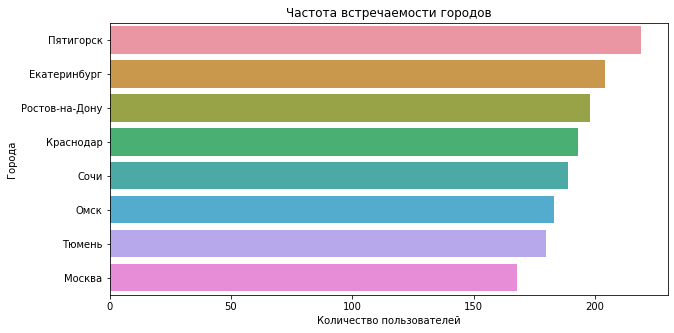

In [32]:
plt.figure(figsize=(10, 5))
ax = sns.barplot(x='user_id', y='city', data=city_count)
plt.title('Частота встречаемости городов')
plt.xlabel('Количество пользователей')
plt.ylabel('Города')
plt.show()

Из графика видно, что больше всего пользователей из Пятигорска (14,28%), Екатеринбурга (13,30%) и Ростова-на-Дону (12,91%). Меньше всего из Москвы - 10,95%

3.2 Соотношение пользователей с подпиской и без подписки

In [33]:
subscription_count = users.groupby('subscription_type')['user_id'].count().sort_values(ascending=False).reset_index()
subscription_count['percentage'] = (subscription_count['user_id'] / users['user_id'].count() * 100).round(2)
subscription_count

,subscription_type,user_id,percentage
0,free,835,54.43
1,ultra,699,45.57


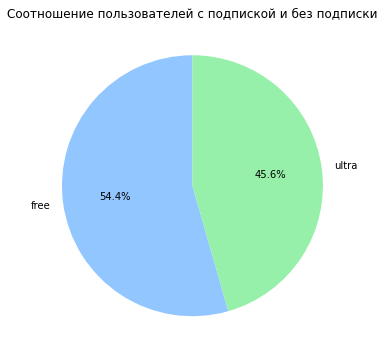

In [34]:
counts = subscription_count['user_id']
labels = subscription_count['subscription_type']

# Вычисление углов для каждого сегмента
angles = counts / counts.sum() * 360

# Строим график
plt.figure(figsize=(6, 6))
plt.pie(counts, labels=labels, autopct='%1.1f%%', startangle=90)
plt.title('Соотношение пользователей с подпиской и без подписки')
plt.show()

Больше половины пользователей пользуются самокатами без подписки (54,4%), остальная часть пользователей оплачивает подписку (45,6%).

In [35]:
users_age = users.groupby('age')['user_id'].count().sort_values(ascending=False).reset_index()
users_age['percentage'] = (users_age['user_id'] / users['user_id'].count() * 100).round(2)
users_age.head(10)

,age,user_id,percentage
0,25,145,9.45
1,24,132,8.60
2,26,131,8.54
3,23,129,8.41
4,27,119,7.76
5,22,119,7.76
6,28,112,7.30
7,21,93,6.06
8,20,71,4.63
9,30,68,4.43


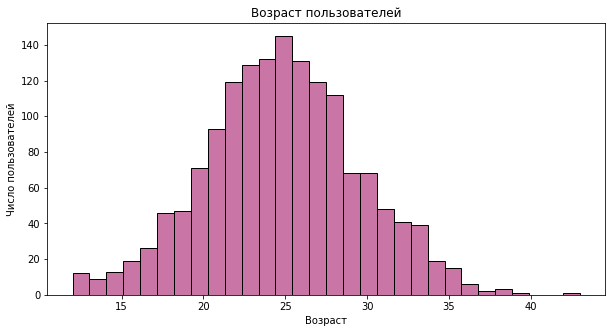

In [36]:
plt.figure(figsize=(10, 5))
ax = sns.histplot(users, x='age', bins=30, color='#b84888')
plt.title('Возраст пользователей')
plt.xlabel('Возраст')
plt.ylabel('Число пользователей')
plt.show()

Больше всего пользователей в возрасте от 22 до 27 лет (суммарно 50,52% от общего числа), самая большая группа - это пользователи, которым 25 лет (9,45%).

3.4 Расстояние, которое пользователь преодолел за одну поездку

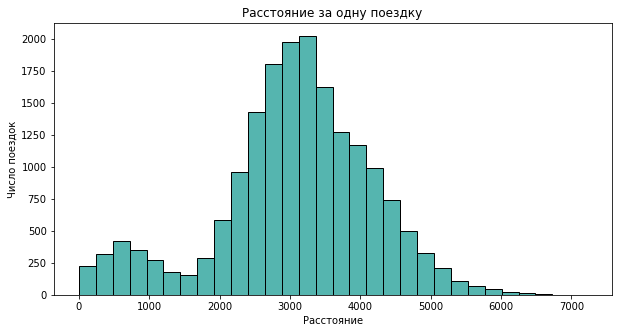

In [37]:
plt.figure(figsize=(10, 5))
ax = sns.histplot(rides, x='distance', bins=30, color='#1c9c95')
plt.title('Расстояние за одну поездку')
plt.xlabel('Расстояние')
plt.ylabel('Число поездок')
plt.show()

In [38]:
rides['distance'].describe()

count    18068.000000
mean      3070.659976
std       1116.831209
min          0.855683
25%       2543.226360
50%       3133.609994
75%       3776.222735
max       7211.007745
Name: distance, dtype: float64

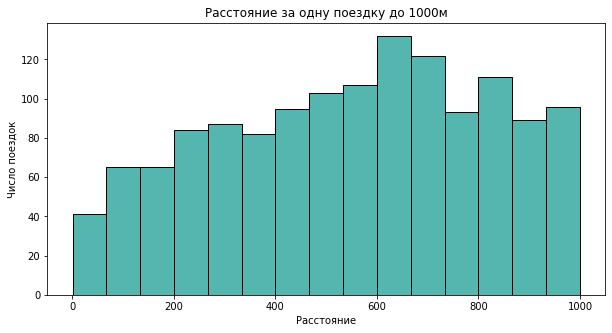

In [39]:
plt.figure(figsize=(10, 5))
ax = sns.histplot(rides.query('distance < 1000'), x='distance', bins=15, color='#1c9c95')
plt.title('Расстояние за одну поездку до 1000м')
plt.xlabel('Расстояние')
plt.ylabel('Число поездок')
plt.show()

Среднее расстояние за одну поездку - примерно 3.1 км. Данные совпадают как по медиане, так и по среднему. Также есть небольшой подъем на отметке в 600м.

3.5 Продолжительность поездок

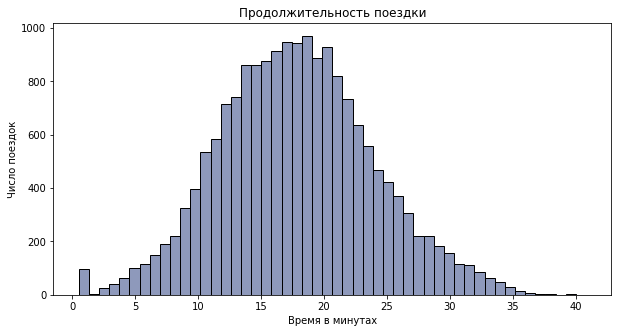

In [40]:
plt.figure(figsize=(10, 5))
ax = sns.histplot(rides, x='duration', bins=50, color='#6977a5')
plt.title('Продолжительность поездки')
plt.xlabel('Время в минутах')
plt.ylabel('Число поездок')
plt.show()

In [41]:
rides['duration'].describe()

count    18068.000000
mean        17.805011
std          6.091051
min          0.500000
25%         13.597563
50%         17.678395
75%         21.724800
max         40.823963
Name: duration, dtype: float64

Средняя продолжительность поездки составляет 17,8 минут. Большая часть всех поездок лежит в диапазоне от 13 до 21 минуты. Есть небольшой всплеск поездок, длительностью всего 1 минута. Возможно, это ошибка в данных.

**Выводы:**

Всего для анализа представлены данные о поездках из 8 городов. Больше всего пользователей из Пятигорска (14,28%), Екатеринбурга (13,30%) и Ростова-на-Дону (12,91%). Меньше всего из Москвы — 10,95%. Почему-то из Москвы пользователей меньше, хотя население там больше. Возможно, это связано с тем, что данный сервис в Москве не так популярен или только открылся.

Больше половины пользователей пользуются самокатами без подписки (54,4%), остальная часть пользователей оплачивает подписку (45,6%).

Если смотреть на возраст пользователей, то почти 50% от всего количества пользователей — это молодые люди в возрасте от 22 до 27 лет.

Среднее расстояние, которое проезжают за одну поездку — это 3,1 км. В среднем для большей части поездок — это расстояние от 2,5 до 3,7 км. Есть небольшой подъем количества поездок на уровне 600-650 метров.

Средняя продолжительность одной поездки составляет 17,8 минут. Для большей части поездок продолжительность составляет от 13 до 21 минуты в пути.

#### Шаг 4. Объединение данных

In [42]:
#объединим данные
df = rides.merge(users, how ='left', on ='user_id')
df = df.merge(subscriptions, how ='left', on='subscription_type')

df.head(10)

,user_id,distance,duration,date,month,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee
0,1,4409.919140,25.599769,2021-01-01,1,Кира,22,Тюмень,ultra,6,0,199
1,1,2617.592153,15.816871,2021-01-18,1,Кира,22,Тюмень,ultra,6,0,199
2,1,754.159807,6.232113,2021-04-20,4,Кира,22,Тюмень,ultra,6,0,199
3,1,2694.783254,18.511000,2021-08-11,8,Кира,22,Тюмень,ultra,6,0,199
4,1,4028.687306,26.265803,2021-08-28,8,Кира,22,Тюмень,ultra,6,0,199
5,1,2770.890808,16.650138,2021-10-09,10,Кира,22,Тюмень,ultra,6,0,199
6,1,3039.020292,14.927879,2021-10-19,10,Кира,22,Тюмень,ultra,6,0,199
7,1,2842.118050,23.117468,2021-11-06,11,Кира,22,Тюмень,ultra,6,0,199
8,1,3412.690668,15.238072,2021-11-14,11,Кира,22,Тюмень,ultra,6,0,199
9,1,748.690645,15.041884,2021-11-22,11,Кира,22,Тюмень,ultra,6,0,199


In [43]:
print(df.shape)
print(users.shape)
print(rides.shape)

(18068, 12)
(1534, 5)
(18068, 5)


In [44]:
# создадим два датафрейма c данными о пользователях без подписки и с подпиской
df_ultra = df.query('subscription_type == "ultra"')
df_free = df.query('subscription_type == "free"')

In [45]:
df_ultra.head()

,user_id,distance,duration,date,month,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee
0,1,4409.919140,25.599769,2021-01-01,1,Кира,22,Тюмень,ultra,6,0,199
1,1,2617.592153,15.816871,2021-01-18,1,Кира,22,Тюмень,ultra,6,0,199
2,1,754.159807,6.232113,2021-04-20,4,Кира,22,Тюмень,ultra,6,0,199
3,1,2694.783254,18.511000,2021-08-11,8,Кира,22,Тюмень,ultra,6,0,199
4,1,4028.687306,26.265803,2021-08-28,8,Кира,22,Тюмень,ultra,6,0,199


In [46]:
df_free.head()

,user_id,distance,duration,date,month,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee
6500,700,2515.690719,14.944286,2021-01-02,1,Айдар,22,Омск,free,8,50,0
6501,700,846.932642,16.234663,2021-02-01,2,Айдар,22,Омск,free,8,50,0
6502,700,4004.434142,20.016628,2021-02-04,2,Айдар,22,Омск,free,8,50,0
6503,700,1205.911290,9.782872,2021-02-10,2,Айдар,22,Омск,free,8,50,0
6504,700,3047.379435,17.427673,2021-02-14,2,Айдар,22,Омск,free,8,50,0


Посмотрим на информацию о расстоянии и времени поездок для пользователей обеих категорий

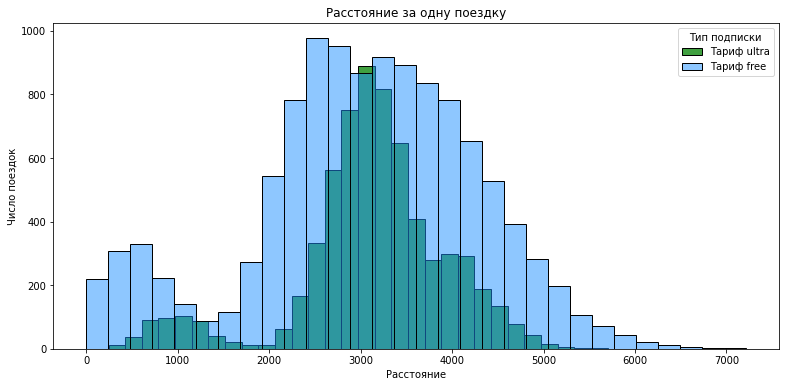

In [47]:
plt.figure(figsize=(13, 6))
ax = sns.histplot(df_ultra['distance'], bins=30, color='green', label='Тариф ultra')
ax = sns.histplot(df_free['distance'], bins=30, color='dodgerblue', alpha=0.5, label='Тариф free')
plt.title('Расстояние за одну поездку')
plt.xlabel('Расстояние')
plt.ylabel('Число поездок')
plt.legend(title='Тип подписки')
plt.show()

По графику видно, что для тарифа ultra наиболее популярны поездки на расстояние примерно в 3 км, а для тарифа free на расстояние чуть меньше — 2,5 км. Причем пользователи с тарифом free совершают больше поездок до 1 км.

In [48]:
df_free['distance'].describe()

count    11568.000000
mean      3045.495282
std       1246.173806
min          0.855683
25%       2366.562689
50%       3114.648465
75%       3905.697894
max       7211.007745
Name: distance, dtype: float64

In [49]:
df_ultra['distance'].describe()

count    6500.000000
mean     3115.445388
std       836.895330
min       244.210438
25%      2785.444017
50%      3148.637229
75%      3560.574425
max      5699.769662
Name: distance, dtype: float64

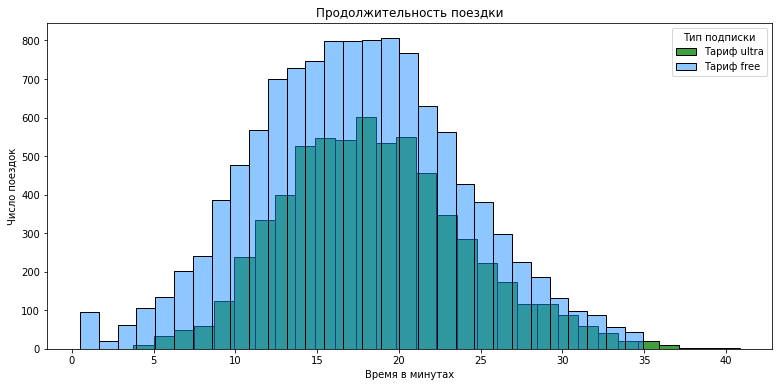

In [50]:
plt.figure(figsize=(13, 6))
ax = sns.histplot(df_ultra['duration'], bins=30, color='green', label='Тариф ultra')
ax = sns.histplot(df_free['duration'], bins=30, color='dodgerblue', alpha=0.5, label='Тариф free')
plt.title('Продолжительность поездки')
plt.xlabel('Время в минутах')
plt.ylabel('Число поездок')
plt.legend(title='Тип подписки')
plt.show()

Среднее время одной поездки для тарифа free составляет 17.3 минут, для тарифа ultra чуть больше - около 18.5 минут. Для тарифа free можно увидеть всплеск на отметке в 1 минуту

In [51]:
df_free['duration'].describe()

count    11568.000000
mean        17.390909
std          6.326803
min          0.500000
25%         12.958437
50%         17.326890
75%         21.594071
max         34.948498
Name: duration, dtype: float64

In [52]:
df_ultra['duration'].describe()

count    6500.000000
mean       18.541985
std         5.572048
min         3.760353
25%        14.524654
50%        18.178153
75%        21.884129
max        40.823963
Name: duration, dtype: float64

**Выводы:**

Для пользователей с тарифом free большая часть поездок приходится на расстояние от 2,3 км до 3,9 км. Для пользователей с тарифом ultra — это поездки от 2,7 км до 3,5 км.

Среднее время в пути для пользователей тарифа free 17,3 минуты, а для тарифа ultra — 18,5 минут. 

Таким образом, можно сказать что в среднем, пользователи тарифа ultra совершают более длинные поездки и находятся в пути дольше, но разница не так значительна.

#### Шаг 5. Подсчёт выручки

In [53]:
#округлим длительность поездок
df['duration'] = np.ceil(df['duration']).astype(int)

5.1 Создадим датафрейм с агрегированными данными о поездках 

In [54]:
df_agg = df.groupby(
    ['user_id', 'name', 'age', 'city', 'subscription_type', 'month',
     'minute_price', 'start_ride_price', 'subscription_fee']).agg({
     'distance': 'sum',
     'duration': 'sum',
     'date': 'count'
}).reset_index()

df_agg.rename(columns={
     'distance': 'total_distance',
     'duration': 'total_duration',
     'date': 'total_rides'
}, inplace=True)

df_agg.head(10)

,user_id,name,age,city,subscription_type,month,minute_price,start_ride_price,subscription_fee,total_distance,total_duration,total_rides
0,1,Кира,22,Тюмень,ultra,1,6,0,199,7027.511294,42,2
1,1,Кира,22,Тюмень,ultra,4,6,0,199,754.159807,7,1
2,1,Кира,22,Тюмень,ultra,8,6,0,199,6723.470560,46,2
3,1,Кира,22,Тюмень,ultra,10,6,0,199,5809.911100,32,2
4,1,Кира,22,Тюмень,ultra,11,6,0,199,7003.499363,56,3
5,1,Кира,22,Тюмень,ultra,12,6,0,199,6751.629942,28,2
6,2,Станислав,31,Омск,ultra,3,6,0,199,10187.723006,63,3
7,2,Станислав,31,Омск,ultra,4,6,0,199,6164.381824,40,2
8,2,Станислав,31,Омск,ultra,6,6,0,199,3255.338202,14,1
9,2,Станислав,31,Омск,ultra,7,6,0,199,6780.722964,48,2


5.2 Добавим столбец с помесячной выручкой, которую принёс каждый пользователь. 

In [55]:
#рассчитаем доход по формуле
df_agg['income'] = (
    df_agg['start_ride_price'] * df_agg['total_rides'] + df_agg['minute_price'] * 
    df_agg['total_duration'] + df_agg['subscription_fee'])
    
df_agg.head(10)

,user_id,name,age,city,subscription_type,month,minute_price,start_ride_price,subscription_fee,total_distance,total_duration,total_rides,income
0,1,Кира,22,Тюмень,ultra,1,6,0,199,7027.511294,42,2,451
1,1,Кира,22,Тюмень,ultra,4,6,0,199,754.159807,7,1,241
2,1,Кира,22,Тюмень,ultra,8,6,0,199,6723.470560,46,2,475
3,1,Кира,22,Тюмень,ultra,10,6,0,199,5809.911100,32,2,391
4,1,Кира,22,Тюмень,ultra,11,6,0,199,7003.499363,56,3,535
5,1,Кира,22,Тюмень,ultra,12,6,0,199,6751.629942,28,2,367
6,2,Станислав,31,Омск,ultra,3,6,0,199,10187.723006,63,3,577
7,2,Станислав,31,Омск,ultra,4,6,0,199,6164.381824,40,2,439
8,2,Станислав,31,Омск,ultra,6,6,0,199,3255.338202,14,1,283
9,2,Станислав,31,Омск,ultra,7,6,0,199,6780.722964,48,2,487


#### Шаг 6. Проверка гипотез

6.1. Важно понять, тратят ли пользователи с подпиской больше времени на поездки? Если да, то пользователи с подпиской могут быть «выгоднее» для компании.

**Гипотеза №1: Пользователи с подпиской тратят больше времени на поездки, чем пользователи без подписки.**

Нулевая гипотеза (H0): Средние значения продолжительности поездок для пользователей с подпиской и без подписки равны.

Альтернативная гипотеза (H1): Средние значения продолжительности поездок для пользователей с подпиской больше, чем у пользователей без подписки.

In [56]:
alpha = 0.05 #уровень статистической значимости

results = st.ttest_ind(df_ultra['duration'], df_free['duration'], alternative='greater')

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не отвергаем нулевую гипотезу')

p-значение: 1.2804098316645618e-34
Отвергаем нулевую гипотезу


In [57]:
print('Среднее время поездки с тарифом ultra:', round(df_ultra['duration'].mean(),2))
print('Среднее время поездки с тарифом free:', round(df_free['duration'].mean(),2))

Среднее время поездки с тарифом ultra: 18.54
Среднее время поездки с тарифом free: 17.39


Вывод: среднее время поездки с тарифом ultra выше, чем с тарифом free. Пользователи с подпиской могут быть выгоднее компании

6.2 Расстояние одной поездки в 3130 метров — оптимальное с точки зрения износа самоката. Можно ли сказать, что среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров? 

**Гипотеза №2: Пользователи с подпиской проезжают в среднем 3130 метров.**

Нулевая гипотеза (H0): Среднее расстояние, которое проезжает пользователь с подпиской, равно 3130 метров.

Альтернативная гипотеза (H1): Среднее расстояние, которое проезжает пользователь с подпиской, больше 3130 метров

In [58]:
interested_value = 3130 

alpha = 0.05 #уровень статистической значимости

results = st.ttest_1samp(df_ultra['distance'], interested_value, alternative='greater')

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение: 0.9195368847849785
Не получилось отвергнуть нулевую гипотезу


In [59]:
print('Среднее расстояние поездки с тарифом ultra:', round(df_ultra['distance'].mean(),2))
print('Среднее расстояние поездки с тарифом free:', round(df_free['distance'].mean(),2))

Среднее расстояние поездки с тарифом ultra: 3115.45
Среднее расстояние поездки с тарифом free: 3045.5


Вывод: среднее расстояние для пользователей с подпиской не превышает значение в 3130 метров

6.3 Проверим гипотезу о том, будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки. 

**Гипотеза №3: Помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки.**

Нулевая гипотеза (H0): Средние значения помесячной выручки от пользователей с подпиской и без подписки равны.

Альтернативная гипотеза (H1): Средние значения помесячной выручки от пользователей с подпиской больше, чем выручка от пользователей без подписки.

In [60]:
df_agg_ultra = df_agg.query('subscription_type == "ultra"')
df_agg_free = df_agg.query('subscription_type == "free"')

alpha = 0.05 #уровень статистической значимости

results = st.ttest_ind(df_agg_ultra['income'], df_agg_free['income'], alternative='greater')

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Нет оснований отвергнуть нулевую гипотезу')

p-значение: 1.8850394384715216e-31
Отвергаем нулевую гипотезу


In [61]:
print('Средняя выручка пользователей с тарифом ultra:', round(df_agg_ultra['income'].mean(),2))
print('Средняя выручка пользователей с тарифом free:', round(df_agg_free['income'].mean(),2))

Средняя выручка пользователей с тарифом ultra: 362.79
Средняя выручка пользователей с тарифом free: 328.64


Вывод: помесячная выручка от пользователей с подпиской в среднем выше, чем от пользователей без подписки

6.4 Представьте такую ситуацию: техническая команда сервиса обновила сервера, с которыми взаимодействует мобильное приложение. Она надеется, что из-за этого количество обращений в техподдержку значимо снизилось. Некоторый файл содержит для каждого пользователя данные о количестве обращений до обновления и после него. Какой тест вам понадобился бы для проверки этой гипотезы?

**Гипотеза №4: Количество обращений от пользователей будет меньше после технического обновления на стороне сервера**

Нулевая гипотеза (H0): Количество обращений до и после обновления серверов равны.

Альтернативная гипотеза (H1): Количество обращений после обновления серверов меньше, чем до обновления.

Для проверки можно использовать тест о равенстве средних для зависимых (парных) выборок. Используя метод scipy.stats.ttest_rel() передать два параметра: данные об обращениях до обновления и после обновления.


**Выводы:**

В результате анализа были проверены несколько гипотез.

На основе полученных данных можно сказать, что пользователи с подпиской, в среднем тратят больше времени на поездки, чем пользователи без подписки.

Среднее время, которое пользователи с подпиской проезжают на самокате, не превышает 3130 метров.

Помесячная выручка от пользователей с подпиской в среднем выше, чем от пользователей без подписки.

Данные свидетельствуют о том, что для компании пользователи с подпиской являются более выгодными, чем пользователи без подписки.


**Общие выводы:**

В результате исследования сервиса аренды самокатов GoFast были проанализированы три датафрейма, которые содержат информацию о пользователях, поездках и подписке.

На этапе предобработки данных были проверены дубликаты и пропуски, добавлены новые столбцы, исправлены некоторые форматы данных. Критичных ошибок не обнаружено.

Всего для анализа представлены данные о поездках из 8 городов. Больше всего пользователей из Пятигорска, Екатеринбурга и Ростова-на-Дону. Меньше всего из Москвы. Возможно, это связано с тем, что данный сервис в Москве не так популярен или только открылся.

Больше половины пользователей пользуются самокатами без подписки (54,4%), остальная часть пользователей оплачивает подписку (45,6%).

Если смотреть на возраст пользователей, то почти 50% от всего количества пользователей — это молодые люди в возрасте от 22 до 27 лет.

Для пользователей с тарифом free большая часть поездок приходится на расстояние от 2,3 км до 3,9 км. Для пользователей с тарифом ultra — это поездки от 2,7 км до 3,5 км. Среднее время в пути для пользователей тарифа free 17,3 минуты, а для тарифа ultra — 18,5 минут.

В результате исследования были проверены несколько гипотез, которые позволили сделать следующие предположения:
- Пользователи с подпиской, в среднем тратят больше времени на поездки, чем пользователи без подписки.
- Среднее время, которое пользователи с подпиской проезжают на самокате, не превышает 3130 метров.
- Помесячная выручка от пользователей с подпиской в среднем выше, чем от пользователей без подписки.

На основе  этих данных можно дать следующие рекомендации для отдела маркетинга:
1) Продвигать сервис платной подписки, т.к. для компании такие пользователи приносят больше прибыли. Использовать различные маркетинговые активности (реклама, рассылка email, пуш-уведомления, акции).

2) Добавить дополнительные преимущества для платной подписки или сделать промо-период с более низкой ценой подписки, чтобы пользователи смогли оценить все преимущества.

3) Развивать маршруты и обновлять парк самокатов, упросить систему регистрации, как вариант. Всплеск активности на 1 минуте использования, возможно, говорит о том, что у пользователей возникли сложности.
